In [1]:
from typing import List,TypedDict

from langchain_community.document_loaders import PyPDFLoader,PyPDFDirectoryLoader
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import  RecursiveCharacterTextSplitter
from langchain_openai import ChatOpenAI
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_huggingface import HuggingFaceEmbeddings
from pydantic import BaseModel

from langgraph.graph import START,StateGraph,END
from dotenv import load_dotenv
import os
import re


d:\Vaibhav_PC\GenerativeAI\GI\Advance_RAG\Campus_RAG\CRAG\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()

OPENROUTER_API_KEY=os.getenv("OPENROUTER_API_KEY")
os.environ["OPENROUTER_API_KEY"]=OPENROUTER_API_KEY

In [42]:
model= ChatOpenAI( base_url="https://openrouter.ai/api/v1",
    api_key=OPENROUTER_API_KEY,
    model= "openrouter/aurora-alpha"
)
model.invoke("hello")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 5, 'total_tokens': 14, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None, 'image_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0, 'video_tokens': 0}, 'cost': 0, 'is_byok': False, 'cost_details': {'upstream_inference_cost': None, 'upstream_inference_prompt_cost': 0, 'upstream_inference_completions_cost': 0}}, 'model_provider': 'openai', 'model_name': 'openrouter/aurora-alpha', 'system_fingerprint': None, 'id': 'chatcmpl-6c436d6397e5f6ef234b6b57', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019c4977-c954-7c32-9503-12988d93ef4e-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 5, 'output_tokens': 9, 'total_tokens': 14, 'input_token_details': {'audio': 0, 'cache_rea

In [4]:
docs = (
    PyPDFLoader("./documents/book1.pdf").load()
    + PyPDFLoader("./documents/book2.pdf").load()
    + PyPDFLoader("./documents/book3.pdf").load()
)

In [5]:
chunks = RecursiveCharacterTextSplitter(chunk_size=900, chunk_overlap=150).split_documents(docs)
for d in chunks:
    d.page_content = d.page_content.encode("utf-8", "ignore").decode("utf-8", "ignore")

In [6]:
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
)


In [7]:
vector_store = FAISS.from_documents(chunks, embeddings)
retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 4})

In [8]:
class State(TypedDict):
    question: str
    docs: List[Document]

    strips: List[str]            # output of decomposition (sentence strips)
    kept_strips: List[str]       # after filtering (kept sentences)
    refined_context: str         # recomposed internal knowledge (joined kept_strips)

    answer: str

In [9]:

def retrieve(state: State) -> State:
    q = state["question"]
    return {"docs": retriever.invoke(q)}

In [10]:
# -----------------------------
# Sentence-level DECOMPOSER
# -----------------------------
def decompose_to_sentences(text: str) -> List[str]:
    text = re.sub(r"\s+", " ", text).strip()
    sentences = re.split(r"(?<=[.!?])\s+", text)
    return [s.strip() for s in sentences if len(s.strip()) > 20]

In [52]:
decompose_to_sentences("""A transformer in deep learning is a type of model architecture that is particularly effective for processing sequential data, such as text. It utilizes mechanisms called self-attention and feedforward neural networks to weigh the importance of different parts of the input data, allowing it to capture long-range dependencies and relationships within the data. Unlike traditional recurrent neural networks (RNNs), transformers do not process data sequentially, which enables them to be more parallelizable and efficient in training. This architecture has become foundational in natural language processing tasks and has led to significant advancements in the field.""")

['A transformer in deep learning is a type of model architecture that is particularly effective for processing sequential data, such as text.',
 'It utilizes mechanisms called self-attention and feedforward neural networks to weigh the importance of different parts of the input data, allowing it to capture long-range dependencies and relationships within the data.',
 'Unlike traditional recurrent neural networks (RNNs), transformers do not process data sequentially, which enables them to be more parallelizable and efficient in training.',
 'This architecture has become foundational in natural language processing tasks and has led to significant advancements in the field.']

In [48]:
# -----------------------------
# FILTER (LLM judge)
# -----------------------------
class KeepOrDrop(BaseModel):
    keep: bool

filter_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a strict relevance filter.\n"
            "Return keep=true only if the sentence directly helps answer the question.\n"
            "Use ONLY the sentence. Output JSON only.",
        ),
        ("human", "Question: {question}\n\nSentence:\n{sentence}"),
    ]
)

filter_chain = filter_prompt | model.with_structured_output(KeepOrDrop)

# -----------------------------
# REFINING (Decompose -> Filter -> Recompose)
# -----------------------------
def refine(state: State) -> State:

    q = state["question"]

    # Combine retrieved docs into one context string
    context = "\n\n".join(d.page_content for d in state["docs"]).strip()

    # 1) DECOMPOSITION: context -> sentence strips
    strips = decompose_to_sentences(context)


    # 2) FILTER: keep only relevant strips
    kept: List[str] = []
    
    for s in strips:
        if filter_chain.invoke({"question": q, "sentence": s}).keep:
        
            kept.append(s)
    print('kept---->',kept)

    # 3) RECOMPOSE: glue kept strips back together (internal knowledge)
    refined_context = "\n".join(kept).strip()

    return {
        "strips": strips,
        "kept_strips": kept,
        "refined_context": refined_context,
    }

In [49]:
answer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful ML tutor. Answer ONLY using the provided refined bullets.\n"
            "If the bullets are empty or insufficient, say: 'I don't know based on the provided books.'",
        ),
        ("human", "Question: {question}\n\nRefined context:\n{refined_context}"),
    ]
)

def generate(state: State) -> State:
    out = (answer_prompt | model).invoke({"question": state["question"], "refined_context": state['refined_context']})
    return {"answer": out.content}

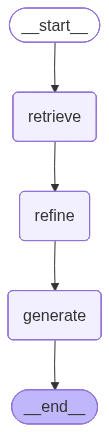

In [50]:
g = StateGraph(State)
g.add_node("retrieve", retrieve)
g.add_node("refine", refine)
g.add_node("generate", generate)

g.add_edge(START, "retrieve")
g.add_edge("retrieve", "refine")
g.add_edge("refine", "generate")
g.add_edge("generate", END)

app = g.compile()

app

In [51]:
res = app.invoke({
    "question": "Explain the bias–variance tradeoff",
    "docs": [],
    "strips": [],
    "kept_strips": [],
    "refined_context": "",
    "answer": ""
})
print(res["answer"])

kept----> ['The Bias-Variance Decomposition 151 Figure 3.6 Plot of squared bias and variance, together with their sum, correspond- ing to the results shown in Fig- ure 3.5.', 'The minimum value of (bias)2 + variance occurs around ln λ = −0.31, which is close to the value that gives the minimum error on the test data.', 'lnλ −3 −2 −1 0 1 2 0 0.03 0.06 0.09 0.12 0.15 (bias)2 variance (bias)2 + variance test error ﬁt a model with 24 Gaussian basis functions by minimizing the regularized error function (3.27) to give a prediction function y(l)(x) as shown in Figure 3.5.', 'We can also examine the bias-variance trade-off quantitatively for this example.', 'The average prediction is estimated from y(x)= 1 L L∑ l=1 y(l)(x) (3.45) and the integrated squared bias and integrated variance are then given by (bias)2 = 1 N N∑ n=1 {y(xn) − h(xn)}2 (3.46) variance = 1 N N∑ n=1 1 L L∑ l=1 { y(l)(xn) − y(xn) }2 (3.47) where the integral over x weighted by the distribution p(x) is approximated by a ﬁnite